In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil

## Import data

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip',
                                      origin=_URL,
                                      extract=True,
                                      cache_dir='.',
                                      cache_subdir='')
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 2s 0us/step


In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
#remove_dir = os.path.join('.', 'cats_and_dogs_filtered')
#shutil.rmtree(remove_dir)

## Load Data

In [ ]:
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
raw_validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

In [ ]:
class_names = raw_train_dataset.class_names

In [ ]:
val_batches = tf.data.experimental.cardinality(raw_validation_dataset)
raw_test_dataset = raw_validation_dataset.take(val_batches // 5) # extract 20% for the test set
raw_validation_dataset = raw_validation_dataset.skip(val_batches // 5) # take the remaining 80%

In [ ]:
print('Number of traning batches: %d' % tf.data.experimental.cardinality(raw_train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(raw_validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(raw_test_dataset))

## Define Data augmentation strategy

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
for image, _ in raw_train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Load the base Model or the feature extractor

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False, # ingnore classification layer, from the bottelneck layer downward
                                               weights='imagenet') # load the trained weights
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

## Build and Compile the model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
      loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
      optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=['accuracy']
  )
history = model.fit(raw_train_dataset,
                    epochs=10,
                    validation_data=raw_validation_dataset)

Epoch 1/10


63/63 [==============================] - 22s 163ms/step - loss: 0.5882 - accuracy: 0.6505 - val_loss: 0.4277 - val_accuracy: 0.8020
Epoch 2/10
63/63 [==============================] - 9s 146ms/step - loss: 0.4438 - accuracy: 0.7810 - val_loss: 0.3193 - val_accuracy: 0.8936
Epoch 3/10
63/63 [==============================] - 8s 129ms/step - loss: 0.3572 - accuracy: 0.8375 - val_loss: 0.2446 - val_accuracy: 0.9369
Epoch 4/10
63/63 [==============================] - 11s 164ms/step - loss: 0.3013 - accuracy: 0.8760 - val_loss: 0.2024 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 9s 145ms/step - loss: 0.2756 - accuracy: 0.8785 - val_loss: 0.1824 - val_accuracy: 0.9468
Epoch 6/10
63/63 [==============================] - 10s 151ms/step - loss: 0.2433 - accuracy: 0.9065 - val_loss: 0.1532 - val_accuracy: 0.9616
Epoch 7/10
63/63 [==============================] - 12s 179ms/step - loss: 0.2299 - accuracy: 0.8995 - val_loss: 0.1419 - val_accuracy: 0.9641
Epoch 8/10
63

## Plot training results (learning curves)

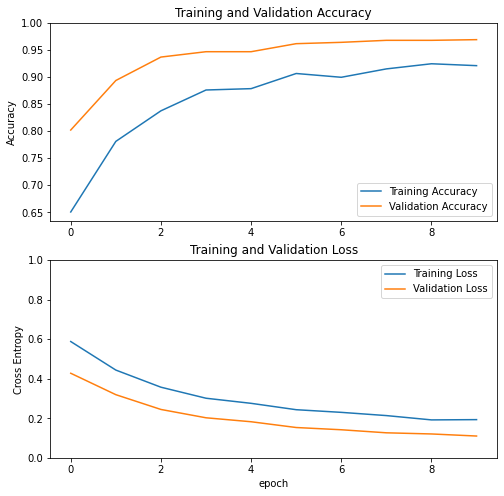

In [ ]:
def plot_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
plot_learning_curves(history)

## Evaluate the model

In [ ]:
test_loss, test_accuracy = model.evaluate(raw_test_dataset)
print("Final loss: {:.2f}".format(test_loss))
print("Final accuracy: {:.2f}".format(test_accuracy))

6/6 [==============================] - 1s 50ms/step - loss: 0.1070 - accuracy: 0.9635
Final loss: 0.11
Final accuracy: 0.96


## Fine-tuning

In [ ]:
base_model.trainable = True
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = model.fit(raw_train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=raw_validation_dataset)

Epoch 10/20


63/63 [==============================] - 21s 155ms/step - loss: 0.1437 - accuracy: 0.9415 - val_loss: 0.0560 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 10s 152ms/step - loss: 0.1126 - accuracy: 0.9550 - val_loss: 0.0494 - val_accuracy: 0.9839
Epoch 12/20
63/63 [==============================] - 10s 150ms/step - loss: 0.1068 - accuracy: 0.9600 - val_loss: 0.0391 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 10s 151ms/step - loss: 0.0903 - accuracy: 0.9590 - val_loss: 0.0409 - val_accuracy: 0.9889
Epoch 14/20
63/63 [==============================] - 10s 151ms/step - loss: 0.0844 - accuracy: 0.9640 - val_loss: 0.0375 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 9s 137ms/step - loss: 0.0735 - accuracy: 0.9715 - val_loss: 0.0354 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 10s 149ms/step - loss: 0.0786 - accuracy: 0.9695 - val_loss: 0.0361 - val_accuracy: 0.9864
Epoch

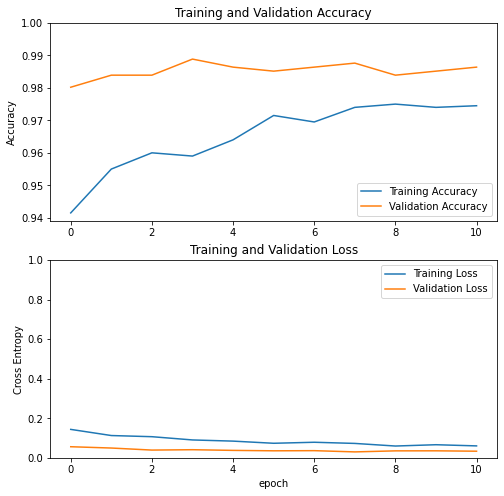

In [ ]:
plot_learning_curves(history_fine)